<a href="https://colab.research.google.com/github/sush0677/Assigment/blob/main/CVAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Thresholding***

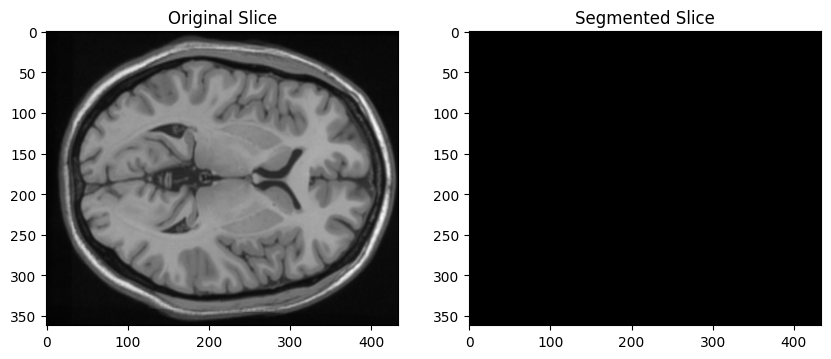

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# Load MRI data
data = loadmat('Brain.mat')
T1 = data['T1']  # MRI images
label = data['label']  # Pre-segmented images

# Function to apply thresholding
def thresholding(image, threshold):
    # Apply threshold
    segmented = np.where(image > threshold, 1, 0)
    return segmented

# Choose a slice to work with
slice_index = 0  # Example: first slice
slice_image = T1[:, :, slice_index]

# Visual inspection to choose a threshold
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(slice_image, cmap='gray')
plt.title('Original Slice')

# Apply thresholding - you may need to adjust this value
threshold_value = 100  # Example threshold value
segmented_slice = thresholding(slice_image, threshold_value)

plt.subplot(1, 2, 2)
plt.imshow(segmented_slice, cmap='gray')
plt.title('Segmented Slice')
plt.show()


# ***Otsu's Method***

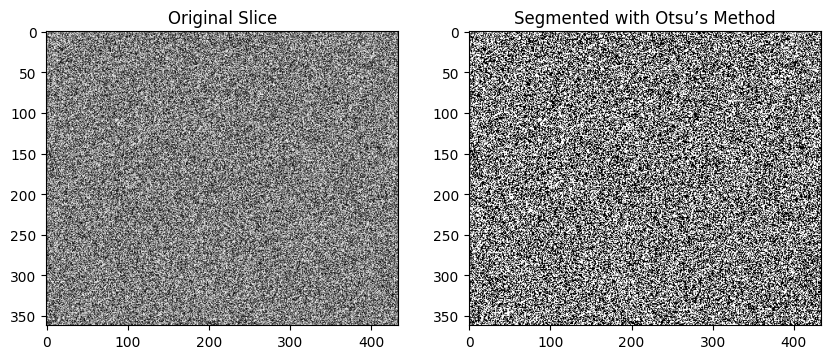

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# Load the data
data = loadmat('Brain.mat')
T1 = data['T1']  # MRI images

# Convert a slice to 8-bit grayscale
slice_index = 0  # Example: first slice
slice_image = T1[:, :, slice_index].astype(np.uint8)

# Apply Otsu's thresholding
ret, thresh = cv2.threshold(slice_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Display the original and segmented images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(slice_image, cmap='gray')
plt.title('Original Slice')
plt.subplot(1, 2, 2)
plt.imshow(thresh, cmap='gray')
plt.title('Segmented with Otsu’s Method')
plt.show()


# ***K-Means Clustering***

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


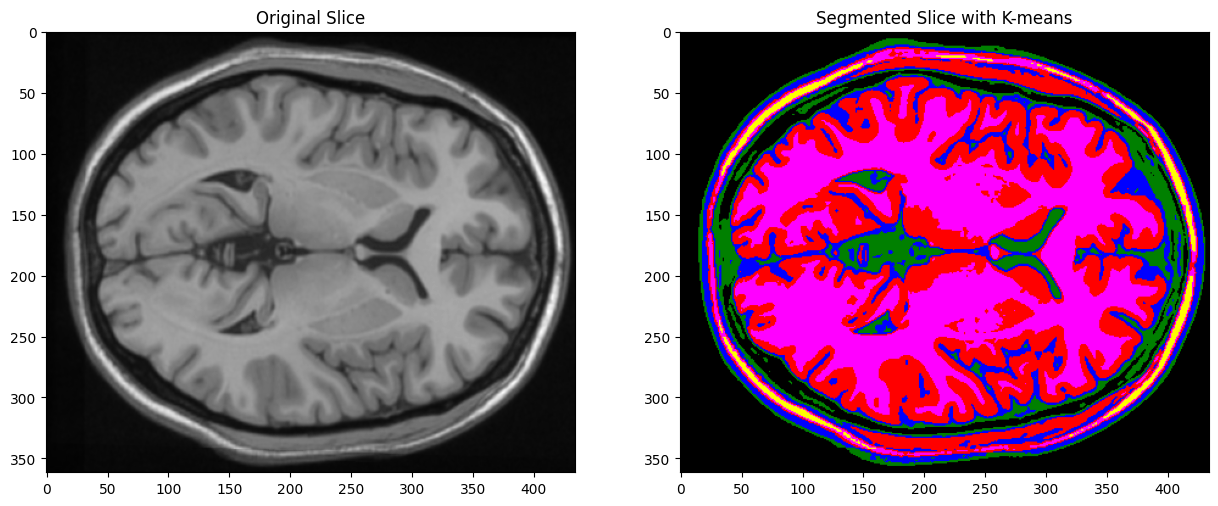

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from skimage.color import label2rgb

# Load MRI data
data = loadmat('Brain.mat')
T1 = data['T1']  # MRI images

# Choose a slice to work with
slice_index = 0  # Example: first slice
slice_image = T1[:, :, slice_index]

# Reshape the image for K-means
image_reshaped = slice_image.reshape((-1, 1))

# Apply K-means clustering
kmeans = KMeans(n_clusters=6, random_state=0).fit(image_reshaped)
segmented = kmeans.labels_.reshape(slice_image.shape)

# Convert segmented image to RGB using label2rgb for visualization
segmented_rgb = label2rgb(segmented, bg_label=0)

# Display the results
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(slice_image, cmap='gray')
plt.title('Original Slice')

plt.subplot(1, 2, 2)
plt.imshow(segmented_rgb)
plt.title('Segmented Slice with K-means')
plt.show()


# ***Watershed***

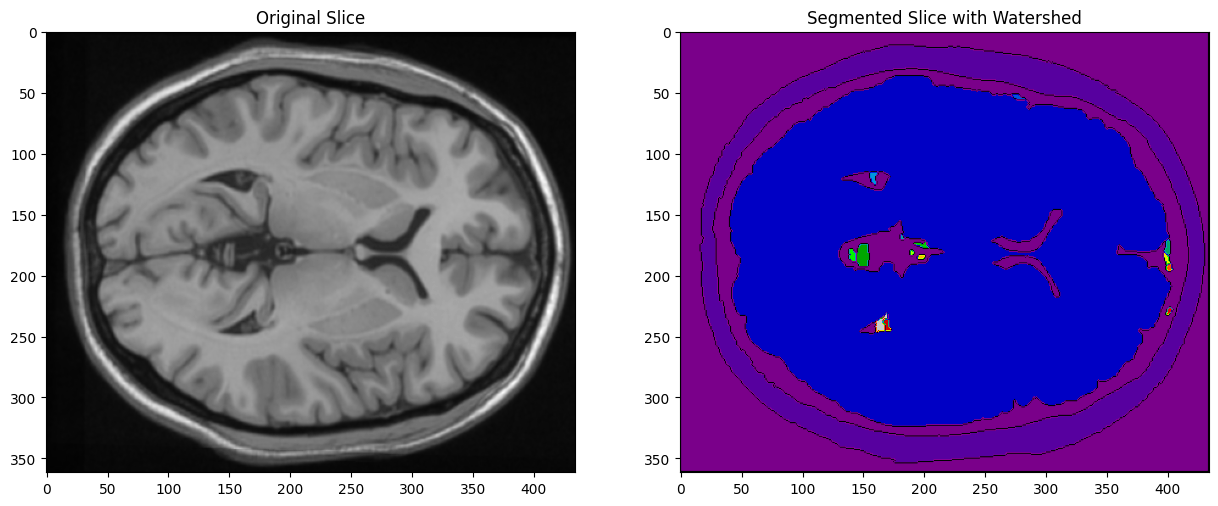

In [5]:
import cv2
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

# Load MRI data
data = loadmat('Brain.mat')
T1 = data['T1']  # MRI images

# Choose a slice to work with
slice_index = 0  # Example: first slice
slice_image = T1[:, :, slice_index].astype(np.float32)  # Ensure the image is a floating-point type

# Normalize the image to the range [0, 255]
slice_image = cv2.normalize(slice_image, None, 0, 255, cv2.NORM_MINMAX)

# Convert the image to 8-bit
slice_image_8u = np.uint8(slice_image)

# Preprocessing: Apply a Gaussian blur to smooth the image
blurred = cv2.GaussianBlur(slice_image_8u, (5, 5), 0)

# Find sure foreground area by applying a threshold
ret, sure_fg = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Find sure background area
sure_bg = cv2.dilate(sure_fg, None, iterations=3)

# Finding unknown region
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1

# Now, mark the region of unknown with zero
markers[unknown == 255] = 0

# Convert markers to the correct type
markers32 = np.int32(markers)

# Apply the watershed algorithm
cv2.watershed(cv2.cvtColor(blurred, cv2.COLOR_GRAY2RGB), markers32)

# Generate the segmentation result
segmented = markers32.copy()
segmented[segmented == -1] = 0
segmented = np.uint8(segmented)

# Display the results
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(slice_image, cmap='gray')
plt.title('Original Slice')

plt.subplot(1, 2, 2)
plt.imshow(segmented, cmap='nipy_spectral')
plt.title('Segmented Slice with Watershed')
plt.show()


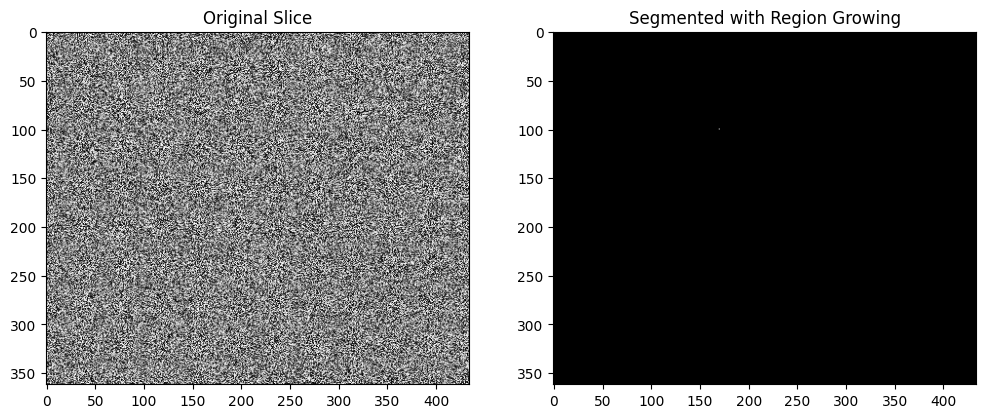

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Dummy function for loading data
def loadmat(file_name):
    # Replace with actual loading of 'Brain.mat'
    return {'T1': np.random.rand(362, 434, 10) * 255}

# Load the example MRI data
data = loadmat('Brain.mat')
slice_image = data['T1'][:, :, 0]  # Taking the first slice for the example

# Define a function for region growing
def region_growing(img, seed):
    neighbors = [(0, -1), (0, 1), (-1, 0), (1, 0)]  # 4-connectivity
    region_value = img[seed]
    segmented_img = np.zeros_like(img)
    dims = img.shape
    to_check = [seed]

    while to_check:
        current_pixel = to_check.pop(0)
        segmented_img[current_pixel] = region_value
        for neighbor in neighbors:
            x = current_pixel[0] + neighbor[0]
            y = current_pixel[1] + neighbor[1]
            if (x >= 0 and x < dims[0]) and (y >= 0 and y < dims[1]):
                if segmented_img[x, y] == 0 and img[x, y] == region_value:
                    to_check.append((x, y))

    return segmented_img

# Apply region growing for a seed point
seed_point = (100, 170)  # Example seed point, you'll need to choose your own
segmented = region_growing(slice_image, seed_point)

# Plotting the result
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(slice_image, cmap='gray')
plt.title('Original Slice')
plt.subplot(1, 2, 2)
plt.imshow(segmented, cmap='gray')
plt.title('Segmented with Region Growing')
plt.show()
